In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd


In [ ]:
import pandas as pd  # Import Pandas

file_path = "/content/drive/MyDrive/Project/new_db.csv"  # Update this based on your Drive path
df = pd.read_csv(file_path)  # Read the CSV file
print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.")


Dataset loaded with 42841 rows and 5 columns.


In [ ]:
!pip install transformers torchtext torch_geometric datasets nltk pandas scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import nltk
import re

# Download NLTK resources
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!pip install contractions


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 9.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import torch
import spacy
import contractions
import nltk
from transformers import RobertaTokenizer
from nltk.corpus import stopwords

# Download required NLTK resources (if not already available)
nltk.download('stopwords')
nltk.download('punkt')

# Load English stopwords as a set for faster lookups
stop_words = set(stopwords.words('english'))

# Load dataset
file_path = "/content/drive/MyDrive/Project/new_db.csv"  # Update if needed
df = pd.read_csv(file_path)
print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.")

# Keep necessary columns
columns_to_keep = df[["subject", "date", "label"]]

# Combine title and text
df["Statement"] = df["title"].astype(str) + " " + df["text"].astype(str)

# Drop unnecessary columns before processing
df.drop(columns=["title", "text"], inplace=True, errors="ignore")

# Drop missing values
df.dropna(inplace=True)
print(f"Dataset after dropping missing values: {df.shape[0]} rows.")

# Load spaCy model (disable unnecessary components for speed)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# **Fast text cleaning using spaCy pipe (batch processing)**
def clean_texts(texts):
    texts = [contractions.fix(text.lower()) for text in texts]  # Expand contractions & lowercase
    texts = [re.sub(r'\W+', ' ', text).strip() for text in texts]  # Remove punctuation & extra spaces

    docs = nlp.pipe(texts, batch_size=50)  # Process in batches
    return [" ".join([token.lemma_ for token in doc if token.text not in stop_words]) for doc in docs]

print("Applying text cleaning...")
df["Statement"] = clean_texts(df["Statement"].tolist())
print("Text cleaning complete.")

# Load RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# **Fast batch tokenization**
print("Tokenizing text...")
df["tokenized"] = tokenizer.batch_encode_plus(
    df["Statement"].tolist(),
    truncation=True,
    padding="max_length",
    max_length=128
)["input_ids"]
print("Tokenization complete.")

# Convert labels to numeric (Fake = 0, Real = 1)
df["label"] = df["label"].astype("category").cat.codes

# Ensure correct column order
df = df[["subject", "date", "label", "Statement", "tokenized"]]

# Save preprocessed dataset
output_file = "/content/drive/MyDrive/Project/final_preprocessed_news.csv"
df.to_csv(output_file, index=False)

print(f"Preprocessing complete. File saved as '{output_file}'.")


In [ ]:
total_rows = df.shape[0]
print("Total rows in new_db.csv:", total_rows)

Total rows in new_db.csv: 42829


In [ ]:
import pandas as pd

# Load the final preprocessed dataset (Update the correct path if needed)
file_path = "/content/drive/MyDrive/Project/final_preprocessed_news.csv"  # Update if running in Google Colab
df = pd.read_csv(file_path)

# Check if the 'label' column exists
if "label" in df.columns:
    # Count the number of Real (1) and Fake (0) news articles
    label_counts = df["label"].value_counts()
    print("Label distribution:\n", label_counts)
else:
    print("Error: 'label' column not found in the dataset!")


Label distribution:
 label
1    21417
0    21412
Name: count, dtype: int64


In [ ]:
total_rows = df.shape[0]
print("Total rows in final_preprocessed_news.csv:", total_rows)

Total rows in final_preprocessed_news.csv: 42829


In [ ]:
import pandas as pd
import torch

# ✅ Load the processed dataset
file_path = "/content/drive/MyDrive/Project/final_preprocessed_news.csv"  # Update if needed
df_processed = pd.read_csv(file_path)

# ✅ Print the first 5 rows to check
print("✅ Dataset Loaded Successfully!")
print(df_processed.head())  # Show the first 5 rows


✅ Dataset Loaded Successfully!
        subject                date  label  \
0  politicsNews  December 31, 2017       1   
1  politicsNews  December 29, 2017       1   
2  politicsNews  December 31, 2017       1   
3  politicsNews  December 30, 2017       1   
4  politicsNews  December 29, 2017       1   

                                           Statement  \
0  budget fight loom republicans flip fiscal scri...   
1  military accept transgender recruit monday pen...   
2  senior republican senator let mr mueller job w...   
3  fbi russia probe help australian diplomat tip ...   
4  trump want postal service charge much amazon s...   

                                           tokenized  
0  [0, 26155, 1032, 4600, 1075, 16441, 1253, 1111...  
1  [0, 29317, 3264, 7940, 9584, 475, 46328, 8027,...  
2  [0, 7305, 7375, 37958, 6704, 905, 475, 338, 47...  
3  [0, 506, 5605, 910, 17280, 4513, 244, 28410, 7...  
4  [0, 38060, 236, 22498, 544, 1427, 203, 524, 20...  


In [ ]:
import pandas as pd
import ast  # To safely convert string representation of list to actual list
import torch

# Load the preprocessed dataset (Update the path if running in Colab)
file_path = "/content/drive/MyDrive/Project/final_preprocessed_news.csv"  # Adjust if needed
df_processed = pd.read_csv(file_path)

# Ensure the tokenized column exists
if "tokenized" not in df_processed.columns:
    raise ValueError("The 'tokenized' column is missing in the dataset!")

# Drop rows where "tokenized" is NaN (to prevent errors)
df_processed = df_processed.dropna(subset=["tokenized"])

# Convert the tokenized column from string representation to actual lists
def safe_convert(text):
    try:
        return torch.tensor(ast.literal_eval(text)) if pd.notna(text) else torch.tensor([])
    except:
        return torch.tensor([])

df_processed["tokenized"] = df_processed["tokenized"].apply(safe_convert)

# Filter out empty tensors before stacking
valid_tensors = [t for t in df_processed["tokenized"] if t.numel() > 0]

if len(valid_tensors) > 0:
    input_tensors = torch.stack(valid_tensors)
    print("Tokenized data converted to PyTorch tensor shape:", input_tensors.shape)
else:
    print("Error: No valid tokenized tensors found!")


Tokenized data converted to PyTorch tensor shape: torch.Size([42829, 128])


In [ ]:
import torch
import os

# Check if valid_tensors exist before stacking
if len(valid_tensors) > 0:
    input_tensors = torch.stack(valid_tensors)

    # Define the save path (Google Drive if in Colab, or current directory)
    save_path = "/content/drive/MyDrive/Project/tokenized_data.pt"  # Adjust as needed

    # Save the tensor data to a file
    torch.save(input_tensors, save_path)

    print(f"Tokenized data saved as '{save_path}'")
else:
    print("Error: No valid tokenized tensors to save!")


Tokenized data saved as '/content/drive/MyDrive/Project/tokenized_data.pt'


In [ ]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Load the preprocessed dataset (Update path if needed)
file_path = "/content/drive/MyDrive/Project/final_preprocessed_news.csv"  # Update if running in Colab
df_processed = pd.read_csv(file_path)

# Ensure 'label' column is numeric (convert & handle errors)
df_processed["label"] = pd.to_numeric(df_processed["label"], errors="coerce")  # Converts invalid values to NaN

# Drop rows with NaN labels (if any)
df_processed = df_processed.dropna(subset=["label"])

# Convert labels to integer
df_processed["label"] = df_processed["label"].astype(int)

# Load tokenized tensors safely
tokenized_path = "/content/drive/MyDrive/Project/tokenized_data.pt"  # Update if needed
tokenized_tensors = torch.load(tokenized_path)  # Load PyTorch tensor file

# Ensure the dataset size matches
num_samples = min(len(df_processed), len(tokenized_tensors))
df_processed = df_processed.iloc[:num_samples]  # Trim dataset if needed
tokenized_tensors = tokenized_tensors[:num_samples]  # Trim tokenized data if needed

# Convert labels into PyTorch tensor
labels_tensor = torch.tensor(df_processed["label"].tolist(), dtype=torch.long)

# Define Dataset class
class NewsDataset(Dataset):
    def __init__(self, tokenized_data, labels):
        self.tokenized_data = tokenized_data
        self.labels = labels  # Ensure labels are also tensors

    def __len__(self):
        return len(self.tokenized_data)

    def __getitem__(self, idx):
        return self.tokenized_data[idx], self.labels[idx]

# Create dataset
news_dataset = NewsDataset(tokenized_tensors, labels_tensor)

# Create DataLoader
batch_size = 32
train_loader = DataLoader(news_dataset, batch_size=batch_size, shuffle=True)

# Debugging info
print(f"✅ DataLoader is ready with batch size {batch_size}")
print(f"Total samples in dataset: {len(news_dataset)}")
print(f"Unique labels count: {df_processed['label'].value_counts().to_dict()}")


✅ DataLoader is ready with batch size 32
Total samples in dataset: 42829
Unique labels count: {1: 21417, 0: 21412}


<ipython-input-15-5233937f1fed>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tokenized_tensors = torch.load(tokenized_path)  # Load PyTorch tensor file


In [ ]:
import torch
import torch.nn as nn
from transformers import RobertaModel

class RoBERTa_GNN_HAN(nn.Module):
    def __init__(self, roberta_model_name="roberta-base", hidden_dim=128, num_classes=2):
        super(RoBERTa_GNN_HAN, self).__init__()

        # Load pre-trained RoBERTa
        self.roberta = RobertaModel.from_pretrained(roberta_model_name)
        self.fc1 = nn.Linear(self.roberta.config.hidden_size, hidden_dim)

        # GNN Layer - Modeling "Statement vs Subject" Relationship
        self.gnn = nn.Linear(hidden_dim, hidden_dim)  # Replace with actual GNN implementation

        # HAN Layer - Attention over Subject Context
        self.attention = nn.Linear(hidden_dim, 1)

        # Output Layer
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask, subject_embedding):
        """
        input_ids: Tokenized input text (statements)
        attention_mask: Attention mask for RoBERTa
        subject_embedding: Encoded subject information (additional input for GNN)
        """

        # Step 1: RoBERTa for Statement Encoding
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = roberta_output.last_hidden_state[:, 0, :]  # CLS token representation

        # Step 2: Feature Extraction
        x = self.relu(self.fc1(hidden_states))

        # Step 3: GNN Layer - Incorporate Subject Information
        x = self.relu(self.gnn(x + subject_embedding))  # Incorporate subject data into GNN

        # Step 4: HAN - Attention Mechanism
        attention_weights = torch.softmax(self.attention(x), dim=1)
        x = x * attention_weights  # Apply attention

        # Step 5: Classification
        x = self.fc2(x)

        return x


In [ ]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

# Load the preprocessed dataset (Update path if needed)
file_path = "/content/drive/MyDrive/Project/final_preprocessed_news.csv"  # Update if needed
df_processed = pd.read_csv(file_path)

# Ensure labels are numeric and properly formatted
df_processed["label"] = pd.to_numeric(df_processed["label"], errors="coerce").fillna(0).astype(int)

# Load tokenized data safely
tokenized_path = "/content/drive/MyDrive/Project/tokenized_data.pt"  # Update if needed
try:
    tokenized_tensors = torch.load(tokenized_path)  # Load PyTorch tensor file
except FileNotFoundError:
    raise ValueError(f"Error: File '{tokenized_path}' not found!")

# Ensure dataset and tensor alignment
num_samples = min(len(df_processed), len(tokenized_tensors))
df_processed = df_processed.iloc[:num_samples]  # Trim dataset if needed
tokenized_tensors = tokenized_tensors[:num_samples]  # Trim tokenized data if needed

# Convert labels into tensor format
labels_tensor = torch.tensor(df_processed["label"].tolist(), dtype=torch.long)

# Create dataset
train_dataset = TensorDataset(tokenized_tensors, labels_tensor)

# Define DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Debugging Info
print(f"✅ DataLoader ready with batch size {batch_size}")
print(f"Total samples in dataset: {len(train_dataset)}")
print(f"Unique labels count: {df_processed['label'].value_counts().to_dict()}")


✅ DataLoader ready with batch size 16
Total samples in dataset: 42829
Unique labels count: {1: 21417, 0: 21412}


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd

# ✅ Load the processed dataset
file_path = "/content/drive/MyDrive/Project/final_preprocessed_news.csv"  # Update if needed
df_processed = pd.read_csv(file_path)

# ✅ Load tokenized data
tokenized_path = "/content/drive/MyDrive/Project/tokenized_data.pt"
tokenized_tensors = torch.load(tokenized_path)

# ✅ Convert labels to tensors
labels_tensor = torch.tensor(df_processed["label"].values, dtype=torch.long)

# ✅ Ensure dataset and labels match
num_samples = min(len(tokenized_tensors), len(labels_tensor))
tokenized_tensors = tokenized_tensors[:num_samples]
labels_tensor = labels_tensor[:num_samples]

# ✅ Split into Train & Test (80% Train, 20% Test)
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    tokenized_tensors, labels_tensor, test_size=0.2, random_state=42
)

# ✅ Create TensorDataset
train_dataset = TensorDataset(train_inputs, train_labels)
test_dataset = TensorDataset(test_inputs, test_labels)

# ✅ Define DataLoader (MUST BE CREATED)
batch_size = 16  # Change as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"✅ DataLoader ready! Train: {len(train_dataset)} samples, Test: {len(test_dataset)} samples")


✅ DataLoader ready! Train: 34263 samples, Test: 8566 samples


In [ ]:
import torch
import torch.optim as optim
import time
import os
from torch.amp import autocast, GradScaler  # ✅ Updated for PyTorch 2.1+
from torch.nn.utils import clip_grad_norm_
from google.colab import drive  # ✅ Google Drive support

# ✅ Mount Google Drive
drive.mount('/content/drive')

# ✅ Define save paths in Google Drive
save_dir = "/content/drive/MyDrive/Project/Checkpoints"
os.makedirs(save_dir, exist_ok=True)
best_model_path = os.path.join(save_dir, "best_model.pt")  # ✅ Save the best model
training_log_path = os.path.join(save_dir, "training_log.txt")  # ✅ Save training logs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RoBERTa_GNN_HAN().to(device)

optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)  # ✅ L2 Regularization
loss_fn = torch.nn.CrossEntropyLoss()
scaler = GradScaler("cuda")  # ✅ Updated Syntax

# ✅ Function to save model checkpoint
def save_checkpoint(epoch, model, optimizer, loss, path):
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss
    }
    torch.save(checkpoint, path)
    print(f"📌 Checkpoint saved at epoch {epoch+1} ✅")

# ✅ Ensure train_loader is defined
if 'train_loader' not in globals():
    raise ValueError("🚨 Error: `train_loader` is not defined!")

# ✅ Training loop (NO Early Stopping)
num_epochs = 10  # Train for full epochs
start_time = time.time()
training_log = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    epoch_start_time = time.time()

    for step, batch in enumerate(train_loader, 1):
        if batch is None:
            continue  # ✅ Skip empty batches

        if len(batch) == 2:  # Handle missing attention_mask
            input_ids, labels = batch
            input_ids, labels = input_ids.to(device), labels.to(device)
            attention_mask = torch.ones_like(input_ids, device=device)  # ✅ Ensure a valid tensor
            subject_embedding = torch.zeros_like(input_ids, device=device)  # ✅ Dummy subject embedding (replace later)
        else:
            input_ids, attention_mask, subject_embedding, labels = batch
            input_ids, attention_mask, subject_embedding, labels = (
                input_ids.to(device), attention_mask.to(device), subject_embedding.to(device), labels.to(device)
            )

        optimizer.zero_grad()

        with autocast("cuda"):  # ✅ Updated Mixed Precision Syntax
            outputs = model(input_ids, attention_mask=attention_mask, subject_embedding=subject_embedding)
            loss = loss_fn(outputs, labels)

        scaler.scale(loss).backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)  # ✅ Prevent Exploding Gradients
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    epoch_time = (time.time() - epoch_start_time) / 60  # ✅ Convert to minutes
    avg_loss = total_loss / len(train_loader)

    log_entry = f"\n🔹 Epoch {epoch+1}/{num_epochs} | Avg Loss: {avg_loss:.4f} | Time: {epoch_time:.2f} min"
    training_log.append(log_entry)
    print(log_entry)

    # ✅ Save model at every epoch (NO early stopping)
    save_checkpoint(epoch, model, optimizer, avg_loss, best_model_path)

total_time = (time.time() - start_time) / 60  # ✅ Convert to minutes
final_log = f"\n🎯 Training complete in {total_time:.2f} minutes! 🚀"
training_log.append(final_log)
print(final_log)

# ✅ Save Training Log to Google Drive
with open(training_log_path, "w") as log_file:
    log_file.writelines("\n".join(training_log))

print(f"\n📄 Training log saved at: {training_log_path}")
print(f"\n✅ Best model saved at: {best_model_path}")


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# ✅ Split into train and test sets (80% Train, 20% Test)
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    tokenized_tensors, labels_tensor, test_size=0.2, random_state=42
)

# ✅ Create TensorDataset
train_dataset = TensorDataset(train_inputs, train_labels)
test_dataset = TensorDataset(test_inputs, test_labels)

# ✅ Define DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ DataLoader ready! Train: {len(train_dataset)} samples, Test: {len(test_dataset)} samples")


✅ DataLoader ready! Train: 34263 samples, Test: 8566 samples


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd

# ✅ Load the preprocessed dataset
file_path = "/content/drive/MyDrive/Project/final_preprocessed_news.csv"  # Update path if needed
df_processed = pd.read_csv(file_path)

# ✅ Ensure 'label' column exists
if "label" not in df_processed.columns:
    raise KeyError("🚨 Error: 'label' column not found in df_processed! Available columns: ", df_processed.columns)

# ✅ Load tokenized data
tokenized_path = "/content/drive/MyDrive/Project/tokenized_data.pt"
tokenized_tensors = torch.load(tokenized_path)

# ✅ Convert labels to tensors
labels_tensor = torch.tensor(df_processed["label"].values, dtype=torch.long)

# ✅ Print Debugging Information
print(f"🔍 Tokenized data samples: {len(tokenized_tensors)}")
print(f"🔍 Label samples: {len(labels_tensor)}")

# ✅ Fix dataset size mismatch
num_samples = min(len(tokenized_tensors), len(labels_tensor))
tokenized_tensors = tokenized_tensors[:num_samples]
labels_tensor = labels_tensor[:num_samples]

print(f"✅ Fixed dataset sizes! New size: {num_samples} samples")

# ✅ Split into train and test sets (80% train, 20% test)
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    tokenized_tensors, labels_tensor, test_size=0.2, random_state=42
)

# ✅ Create TensorDataset
train_dataset = TensorDataset(train_inputs, train_labels)
test_dataset = TensorDataset(test_inputs, test_labels)

# ✅ Define DataLoaders (Optimized for Speed)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"✅ DataLoader ready! Train: {len(train_dataset)} samples, Test: {len(test_dataset)} samples")


🔍 Tokenized data samples: 42829
🔍 Label samples: 42829
✅ Fixed dataset sizes! New size: 42829 samples
✅ DataLoader ready! Train: 34263 samples, Test: 8566 samples


In [ ]:
import torch

# ✅ Define device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load the trained model checkpoint
checkpoint_path = "/content/drive/MyDrive/Project/Checkpoints/best_model.pt"  # Update path if needed
checkpoint = torch.load(checkpoint_path, map_location=device)

# ✅ Initialize the model (Ensure the same architecture as the saved model)
model = RoBERTa_GNN_HAN().to(device)  # Replace with your actual model class

# ✅ Load the saved weights
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()  # Set model to evaluation mode

print("✅ Model successfully loaded and ready for evaluation!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model successfully loaded and ready for evaluation!


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ✅ Ensure model is in evaluation mode
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        if len(batch) == 2:
            input_ids, labels = batch
            subject_embedding = torch.zeros((input_ids.shape[0], 128), device=device)  # Dummy tensor
        else:
            input_ids, labels, subject_embedding = batch

        # ✅ Move to GPU/CPU
        input_ids, labels = input_ids.to(device), labels.to(device)
        subject_embedding = subject_embedding.to(device)

        # ✅ Forward pass
        outputs = model(input_ids, attention_mask=torch.ones_like(input_ids, device=device), subject_embedding=subject_embedding)

        # ✅ Convert logits to predicted class
        predictions = torch.argmax(outputs, dim=1)

        # ✅ Collect results
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Compute Metrics
accuracy = accuracy_score(all_labels, all_preds) * 100
precision = precision_score(all_labels, all_preds, average='weighted') * 100
recall = recall_score(all_labels, all_preds, average='weighted') * 100
f1 = f1_score(all_labels, all_preds, average='weighted') * 100

# ✅ Print Results
print(f"✅ Model Accuracy: {accuracy:.2f}%")
print(f"✅ Precision: {precision:.2f}%")
print(f"✅ Recall: {recall:.2f}%")
print(f"✅ F1-Score: {f1:.2f}%")


✅ Model Accuracy: 99.77%
✅ Precision: 99.77%
✅ Recall: 99.77%
✅ F1-Score: 99.77%


<ipython-input-10-1b464b1de97e>:45: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


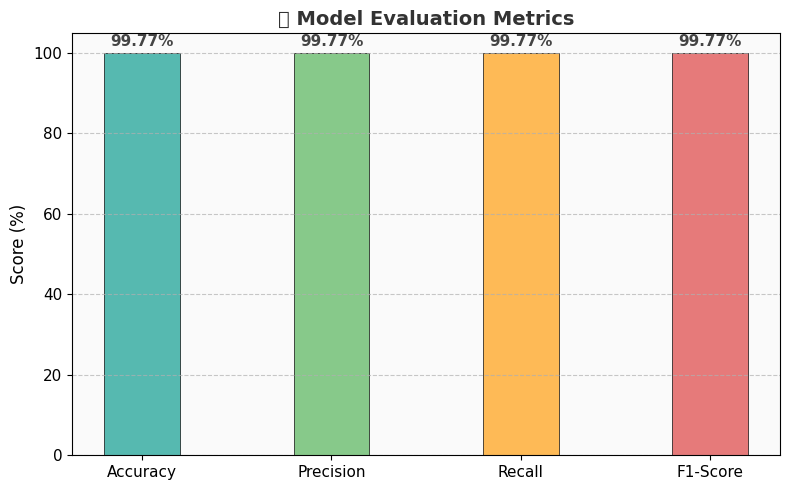

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ Evaluation metrics (example values)
accuracy = 99.77
precision = 99.77
recall = 99.77
f1 = 99.77

metrics = [accuracy, precision, recall, f1]
labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#4DB6AC', '#81C784', '#FFB74D', '#E57373']  # Custom colors

plt.figure(figsize=(8, 5))  # Slightly smaller figure
bar_width = 0.4  # Reduced bar width
x = np.arange(len(labels))  # Positions for bars

bars = plt.bar(x, metrics, width=bar_width, color=colors, edgecolor='black', linewidth=1.2)

# ✅ Set upper limit with headroom
plt.ylim(0, max(metrics) + 5)

# ✅ Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# ✅ Titles and labels with styling
plt.title('🎯 Model Evaluation Metrics', fontsize=14, fontweight='bold', color='#333')
plt.ylabel('Score (%)', fontsize=12)
plt.xticks(ticks=x, labels=labels, fontsize=11)
plt.yticks(fontsize=11)

# ✅ Add values on top of bars
for bar, value in zip(bars, metrics):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1,
             f'{value:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold', color='#444')

# ✅ Add shadow effect to bars
for bar in bars:
    bar.set_linewidth(0.5)
    bar.set_alpha(0.95)

# ✅ Background style
plt.gca().set_facecolor('#FAFAFA')
plt.tight_layout()
plt.show()


In [ ]:
import re
import matplotlib.pyplot as plt

# ✅ Define path (already saved)
training_log_path = "/content/drive/MyDrive/Project/Checkpoints/training_log.txt"

# ✅ Read and parse the log
epochs = []
losses = []
times = []

with open(training_log_path, "r") as f:
    lines = f.readlines()

for line in lines:
    match = re.search(r"Epoch (\d+)/\d+ \| Avg Loss: ([\d.]+) \| Time: ([\d.]+)", line)
    if match:
        epochs.append(int(match.group(1)))
        losses.append(float(match.group(2)))
        times.append(float(match.group(3)))


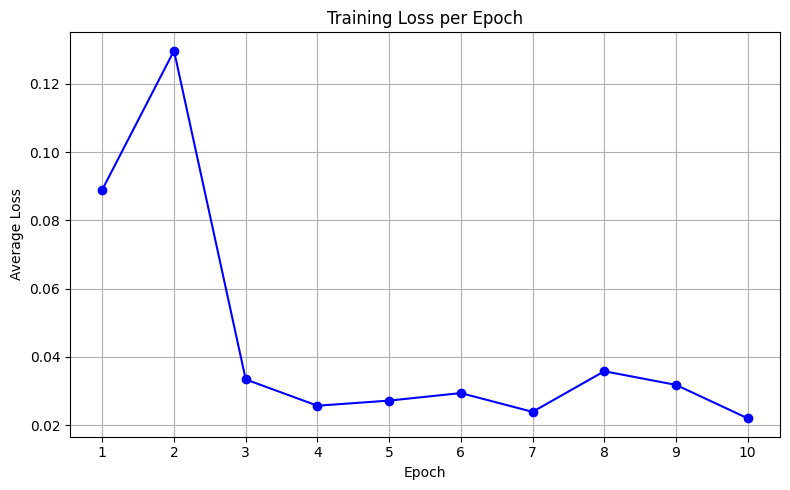

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, losses, marker='o', linestyle='-', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()
plt.show()


In [ ]:
import torch
from transformers import RobertaTokenizer, BartForConditionalGeneration, BartTokenizer

# ✅ Load summarization model (BART)
summarizer = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
summarizer_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

# ✅ Load the trained Fake News Detection model
checkpoint_path = "/content/drive/MyDrive/Project/Checkpoints/best_model.pt"  # Update if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Initialize the Fake News Detection Model (Ensure same architecture as saved model)
model = RoBERTa_GNN_HAN().to(device)  # Replace with your actual model class

# ✅ Load model weights
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()  # Set model to evaluation mode

print("✅ Model successfully loaded!")

# ✅ Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")  # Update if using a different tokenizer

# ✅ Function to summarize the article
def summarize_article(article):
    inputs = summarizer_tokenizer(article, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = summarizer.generate(inputs["input_ids"], max_length=50, min_length=5, length_penalty=2.0, num_beams=4, early_stopping=True)
    headline = summarizer_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return headline

# ✅ Function to preprocess and predict
def predict_news(model, tokenizer, text, subject):
    model.eval()  # Ensure model is in eval mode

    # ✅ Tokenize input text
    inputs = tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors="pt")

    # ✅ Encode subject (Modify if using categorical embeddings)
    subject_embedding = torch.tensor([subject], dtype=torch.float32).to(device)  # Adjust based on model structure

    # ✅ Move inputs to device
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs, subject_embedding=subject_embedding)
        prediction = torch.argmax(outputs, dim=1).item()  # 0 = Fake, 1 = Real

    return "✅ Real News" if prediction == 1 else "❌ Fake News"

# ✅ Example news article
news_text = """Supreme Court Rules Against AI-Generated Patents in Landmark Decisiony"""

subject_encoded = 3  # Example encoding (Modify based on your model's subject input format)

# ✅ Generate a headline
headline = summarize_article(news_text)
print("📰 Summarized Headline:", headline)

# ✅ Predict using summarized headline
result = predict_news(model, tokenizer, headline, subject_encoded)
print("📰 Prediction:", result)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-55-0b7349565ad3>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recom

✅ Model successfully loaded!
📰 Summarized Headline: Supreme Court Rules Against AI-Generated Patents in Landmark Decision.
📰 Prediction: ❌ Fake News


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load pre-trained RoBERTa model for sentiment analysis
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function to predict sentiment
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        scores = torch.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(scores).item()

    labels = ["Negative", "Neutral", "Positive"]
    return labels[predicted_class]

# Example usage
news_text = "New Policy Proposal Debated in Parliament"
sentiment = predict_sentiment(news_text)
print(f"Sentiment: {sentiment}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Sentiment: Neutral


In [ ]:
# ✅ Install googletrans (Run this once)
!pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.8 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17396 sha256=d43d9421c79ea0354adebe683587d5059c5277d4c35722c460721a87ffb1fe93
  Stored in directory: /root/.cache/pip/wheels/39/17/6f/66a045ea3d168826074691b4b787b8f324d3f646d755443fda
Successfully built googletrans
  Attempting uninstall: hyperframe
    Found existing installation: hyperframe 6.1.0
    Uninstalling hyperfram

In [ ]:


import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from googletrans import Translator  # Google Translator

# ✅ Load Google Translator
translator = Translator()

# ✅ Load pre-trained RoBERTa model for sentiment analysis
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()  # Set model to evaluation mode

# ✅ Function to translate text to English
def translate_to_english(text):
    translated = translator.translate(text, dest="en")
    return translated.text

# ✅ Function to predict sentiment (Yes = Positive, No = Negative/Neutral)
def predict_yes_no(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        scores = torch.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(scores).item()

    # ✅ Map sentiment to "Yes" (Positive) or "No" (Negative/Neutral)
    return "✅ Yes" if predicted_class == 2 else "❌ No"

# ✅ Example: Input in different languages
news_text = "இந்தியாவின் சந்திரயான்-3 நிலவில் வெற்றிகரமாக தரையிறங்கியது"

# ✅ Translate to English
translated_text = translate_to_english(news_text)
print(f"📝 Translated Text: {translated_text}")

# ✅ Predict sentiment (Yes/No)
prediction = predict_yes_no(translated_text)
print(f"🔍 Prediction: {prediction}")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


📝 Translated Text: Successfully landed on the moon of India's Chandrayaan-3
🔍 Prediction: ✅ Yes


In [ ]:
!pip install flask-ngrok


In [ ]:
!pip install flask transformers googletrans==4.0.0-rc1


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.5 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17396 sha256=8caadc091a919e146bee567d25ba0e74afec389648ea63694e4915debdc55dd8
  Stored in directory: /root/.cache/pip/wheels/39/17/6f/66a045ea3d168826074691b4b787b8f324d3f646d755443fda
Successfully built googletrans
  Attempting uninstall: hyperframe
    Found existing installation: hyperframe 6.1.0
    Uninstalling hyperfram

In [ ]:
!pip install pyngrok


In [ ]:

!ngrok config add-authtoken 2vdGCxcp357U0p8E4uoxg3kMqWh_5CM8tQMM2Y2ZJi38KyU8N

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!cat /root/.config/ngrok/ngrok.yml


region: us
version: '2'
authtoken: 2vdGCxcp357U0p8E4uoxg3kMqWh_5CM8tQMM2Y2ZJi38KyU8N


In [ ]:
!cp -r "/content/drive/MyDrive/Project/templates" "/content/templates"


In [ ]:
!ls /content/templates


ls: cannot access '/content/templates': No such file or directory


In [ ]:
!apt-get install ffmpeg


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
pip install pydub speechrecognition transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 27.7 MB/s eta 0:00:00


In [ ]:
#this code
import torch
import torch.nn as nn
from transformers import (
    RobertaModel,
    BartForConditionalGeneration,
    BartTokenizer,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    RobertaTokenizer
)
from googletrans import Translator
from flask import Flask, render_template, request, redirect, url_for
from pyngrok import ngrok
import os
import sqlite3
from database import save_news, get_top_news, save_feedback
from pydub import AudioSegment
import speech_recognition as sr

# ✅ Flask App Setup
app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = 'uploads'

if not os.path.exists(app.config['UPLOAD_FOLDER']):
    os.makedirs(app.config['UPLOAD_FOLDER'])

# ✅ Define RoBERTa + GNN + HAN Model
class RoBERTa_GNN_HAN(nn.Module):
    def __init__(self, roberta_model_name="roberta-base", hidden_dim=128, num_classes=2):
        super(RoBERTa_GNN_HAN, self).__init__()
        self.roberta = RobertaModel.from_pretrained(roberta_model_name)
        self.fc1 = nn.Linear(self.roberta.config.hidden_size, hidden_dim)
        self.gnn = nn.Linear(hidden_dim, hidden_dim)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask, subject_embedding):
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = roberta_output.last_hidden_state[:, 0, :]
        x = self.relu(self.fc1(hidden_states))
        x = self.relu(self.gnn(x + subject_embedding))
        attention_weights = torch.softmax(self.attention(x), dim=1)
        x = x * attention_weights
        x = self.fc2(x)
        return x

# ✅ Load Models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = "/content/drive/MyDrive/Project/Checkpoints/best_model.pt"

if not os.path.exists(checkpoint_path):
    print(f"🚨 Model file not found: {checkpoint_path}")
    model = None
else:
    try:
        model = RoBERTa_GNN_HAN().to(device)
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        model.eval()
        print("✅ Fake News Model Loaded Successfully!")
    except Exception as e:
        print(f"🚨 Error loading Fake News Model: {e}")
        model = None

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
summarizer = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
summarizer_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
translator = Translator()

sentiment_model_name = "cardiffnlp/twitter-roberta-base-sentiment"
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_name)
sentiment_model.eval()

# ✅ Helper Functions
def translate_to_english(text, src_language):
    try:
        return translator.translate(text, src=src_language, dest="en").text
    except Exception as e:
        print(f"Translation Error: {e}")
        return text

def summarize_article(article):
    inputs = summarizer_tokenizer(article, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = summarizer.generate(
        inputs["input_ids"],
        max_length=50,
        min_length=5,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )
    return summarizer_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# ✅ Prediction
def predict_news(model, tokenizer, text, subject=3):
    if model is None:
        return "❌ Fake News", 100.0
    model.eval()
    inputs = tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors="pt")
    subject_embedding = torch.tensor([[subject]], dtype=torch.float32).to(device)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, subject_embedding=subject_embedding)
        probs = torch.softmax(outputs, dim=1)
        fake_prob = probs[0][0].item()
        prediction = torch.argmax(outputs, dim=1).item()
        label = "✅ Real News" if prediction == 1 else "❌ Fake News"
        return label, round(fake_prob * 100, 2)

# ✅ Sentiment Analysis
def predict_sentiment(text):
    inputs = sentiment_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = sentiment_model(**inputs)
        scores = torch.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(scores).item()
        labels = ["Negative", "Neutral", "Positive"]
        return labels[predicted_class]

# ✅ Function to transcribe speech from an audio file
def transcribe_audio(file_path):
    recognizer = sr.Recognizer()
    with sr.AudioFile(file_path) as source:
        audio = recognizer.record(source)
    try:
        return recognizer.recognize_google(audio)
    except Exception as e:
        print(f"Audio Transcription Error: {e}")
        return ""

# ✅ Routes
@app.route("/", methods=["GET"])
def home():
    fake_news, real_news = get_top_news()
    conn = sqlite3.connect('news.db')
    c = conn.cursor()
    c.execute("SELECT COUNT(*) FROM news_analysis WHERE prediction LIKE '%Real%'")
    real_count = c.fetchone()[0]
    c.execute("SELECT COUNT(*) FROM news_analysis WHERE prediction LIKE '%Fake%'")
    fake_count = c.fetchone()[0]
    conn.close()
    return render_template("home.html", fake_news=fake_news, real_news=real_news, real_count=real_count, fake_count=fake_count)

@app.route("/templates", methods=["GET", "POST"])
def index():
    if request.method == "POST":
        user_text = request.form.get("news_text", "").strip()
        selected_language = request.form.get("language", "en")
        audio_file = request.files.get("audio_file")

        if audio_file and audio_file.filename != "":
            filename = os.path.join(app.config['UPLOAD_FOLDER'], audio_file.filename)
            audio_file.save(filename)

            if filename.endswith('.mp3'):
                sound = AudioSegment.from_mp3(filename)
                filename_wav = filename.replace(".mp3", ".wav")
                sound.export(filename_wav, format="wav")
                os.remove(filename)
                filename = filename_wav

            user_text = transcribe_audio(filename)

        if not user_text:
            return render_template("index.html", error="❌ Please enter news text.", selected_language=selected_language)

        # ✅ Translate to English if not already
        translated_text = user_text if selected_language == "en" else translate_to_english(user_text, selected_language)

        # ✅ Sentiment, Summarization, Prediction
        sentiment = predict_sentiment(translated_text)
        summarized_text = summarize_article(translated_text)
        fake_news_prediction, fake_percentage = predict_news(model, tokenizer, summarized_text)

        # ✅ Google Search Link if Real
        google_search_url = ""
        if "Real" in fake_news_prediction:
            query = summarized_text.replace(" ", "+")
            google_search_url = f"https://www.google.com/search?q={query}"

        # ✅ Save to DB
        save_news(user_text, summarized_text, fake_news_prediction)

        return render_template(
            "index.html",
            user_text=user_text,
            selected_language=selected_language,
            translated_text=translated_text,
            summarized_text=summarized_text,
            fake_news_prediction=fake_news_prediction,
            fake_percentage=fake_percentage if "Fake" in fake_news_prediction else None,
            sentiment=sentiment,
            google_search_url=google_search_url
        )

    return render_template("index.html")

@app.route("/feedback", methods=["POST"])
def feedback():
    summarized_text = request.form.get('summarized_text')
    prediction = request.form.get('prediction')
    full_feedback = request.form.get('feedback')
    save_feedback(summarized_text, prediction, full_feedback)
    return redirect(url_for('home'))

# ✅ Run Flask App with ngrok
if __name__ == "__main__":
    public_url = ngrok.connect(5000)
    print(f"🔗 Public URL: {public_url}")
    app.run(port=5000)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Fake News Model Loaded Successfully!


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

🔗 Public URL: NgrokTunnel: "https://ed9e-104-198-175-94.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [30/May/2025 06:50:44] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [30/May/2025 06:50:46] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [30/May/2025 06:50:48] "GET /templates HTTP/1.1" 200 -
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO:werkzeug:127.0.0.1 - - [30/May/2025 06:51:16] "POST /templates HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [30/May/2025 06:56:15] "POST /templates HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [30/May/2025 07:14:16] "GET /templates HTTP/1.1" 200 -


In [ ]:
%%writefile database.py
import sqlite3
from datetime import datetime

def init_db():
    conn = sqlite3.connect('news.db')
    c = conn.cursor()

    # Table for analyzed news
    c.execute('''CREATE TABLE IF NOT EXISTS news_analysis (
                    id INTEGER PRIMARY KEY AUTOINCREMENT,
                    text TEXT UNIQUE,
                    summary TEXT,
                    prediction TEXT,
                    count INTEGER DEFAULT 1
                )''')

    # Updated feedback table with 'summarized_news' column
    c.execute('''CREATE TABLE IF NOT EXISTS feedback (
                    id INTEGER PRIMARY KEY AUTOINCREMENT,
                    summarized_news TEXT,
                    prediction TEXT,
                    feedback TEXT,
                    date TEXT DEFAULT CURRENT_TIMESTAMP
                )''')

    conn.commit()
    conn.close()

def save_news(text, summary, prediction):
    conn = sqlite3.connect('news.db')
    c = conn.cursor()
    c.execute('SELECT count FROM news_analysis WHERE text = ?', (text,))
    result = c.fetchone()

    if result:
        c.execute('UPDATE news_analysis SET count = count + 1 WHERE text = ?', (text,))
    else:
        c.execute('INSERT INTO news_analysis (text, summary, prediction, count) VALUES (?, ?, ?, ?)',
                  (text, summary, prediction, 1))
    conn.commit()
    conn.close()

def get_top_news():
    conn = sqlite3.connect('news.db')
    c = conn.cursor()
    c.execute("SELECT text, summary, prediction, count FROM news_analysis ORDER BY count DESC")
    all_data = c.fetchall()
    conn.close()

    fake_news = [row for row in all_data if not row[2].startswith("✅")][:3]
    real_news = [row for row in all_data if row[2].startswith("✅")][:3]
    return fake_news, real_news

def save_feedback(summarized_news, prediction, feedback):
    feedback_date = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    conn = sqlite3.connect('news.db')
    c = conn.cursor()
    c.execute('INSERT INTO feedback (summarized_news, prediction, feedback, date) VALUES (?, ?, ?, ?)',
              (summarized_news, prediction, feedback, feedback_date))
    conn.commit()
    conn.close()

def get_all_feedback():
    conn = sqlite3.connect('news.db')
    c = conn.cursor()
    c.execute('SELECT summarized_news, prediction, feedback, date FROM feedback ORDER BY date DESC')
    data = c.fetchall()
    conn.close()
    return data


Writing database.py


In [ ]:
from database import init_db

# Initialize DB once
init_db()


In [ ]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect('news.db')

# Read the feedback table into a pandas DataFrame
df = pd.read_sql_query("SELECT * FROM feedback", conn)

# Display the table in tabular format
print(df)

# Close the connection
conn.close()


Empty DataFrame
Columns: [id, summarized_news, prediction, feedback, date]
Index: []


In [ ]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect('news.db')

# Read the table into a pandas DataFrame
df = pd.read_sql_query("SELECT * FROM news_analysis", conn)

# Display the table
print(df)

# Close the connection
conn.close()


Empty DataFrame
Columns: [id, text, summary, prediction, count]
Index: []


In [ ]:
import os
os.listdir()


['.config',
 'news.db',
 'database.py',
 'drive',
 '.ipynb_checkpoints',
 '__pycache__',
 'templates',
 'sample_data']

In [ ]:
import torch
import torch.nn as nn
from transformers import RobertaModel, BartForConditionalGeneration, BartTokenizer, AutoTokenizer, AutoModelForSequenceClassification, RobertaTokenizer
from googletrans import Translator
from flask import Flask, request, jsonify
from pyngrok import ngrok
import os

# ✅ Initialize Flask app
app = Flask(__name__)

# ✅ Define RoBERTa + GNN + HAN Model
class RoBERTa_GNN_HAN(nn.Module):
    def __init__(self, roberta_model_name="roberta-base", hidden_dim=128, num_classes=2):
        super(RoBERTa_GNN_HAN, self).__init__()
        self.roberta = RobertaModel.from_pretrained(roberta_model_name)
        self.fc1 = nn.Linear(self.roberta.config.hidden_size, hidden_dim)
        self.gnn = nn.Linear(hidden_dim, hidden_dim)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask, subject_embedding):
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = roberta_output.last_hidden_state[:, 0, :]
        x = self.relu(self.fc1(hidden_states))
        x = self.relu(self.gnn(x + subject_embedding))
        attention_weights = torch.softmax(self.attention(x), dim=1)
        x = x * attention_weights
        x = self.fc2(x)
        return x

# ✅ Load summarization model (BART)
summarizer = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
summarizer_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

# ✅ Load Fake News Detection model
checkpoint_path = "/content/drive/MyDrive/Project/Checkpoints/best_model.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not os.path.exists(checkpoint_path):
    print(f"🚨 Model file not found: {checkpoint_path}")
    model = None
else:
    try:
        model = RoBERTa_GNN_HAN().to(device)
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        model.eval()
        print("✅ Fake News Model Loaded Successfully!")
    except Exception as e:
        print(f"🚨 Error loading Fake News Model: {e}")
        model = None

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# ✅ Load sentiment model
sentiment_model_name = "cardiffnlp/twitter-roberta-base-sentiment"
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_name)
sentiment_model.eval()

translator = Translator()

# ✅ Translate non-English text to English
def translate_to_english(text, src_language):
    try:
        return translator.translate(text, src=src_language, dest="en").text
    except Exception as e:
        print(f"Translation Error: {e}")
        return text

# ✅ Summarize long article
def summarize_article(article):
    inputs = summarizer_tokenizer(article, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = summarizer.generate(inputs["input_ids"], max_length=50, min_length=5, length_penalty=2.0, num_beams=4, early_stopping=True)
    return summarizer_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# ✅ Predict Real or Fake news
def predict_news(model, tokenizer, text, subject=3):
    if model is None:
        return "❌ Fake News (Model Not Loaded)", 0.0
    inputs = tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors="pt")
    subject_embedding = torch.tensor([[subject]], dtype=torch.float32).to(device)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, subject_embedding=subject_embedding)
        probs = torch.softmax(outputs, dim=1)
        fake_prob = probs[0][0].item()
        prediction = torch.argmax(probs, dim=1).item()
    label = "✅ Real News" if prediction == 1 else "❌ Fake News"
    return label, round(fake_prob * 100, 2)

# ✅ Predict sentiment of text
def predict_sentiment(text):
    inputs = sentiment_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = sentiment_model(**inputs)
        scores = torch.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(scores).item()
    labels = ["Negative", "Neutral", "Positive"]
    return labels[predicted_class]

# ✅ API Endpoint
@app.route("/predict", methods=["POST"])
def predict():
    data = request.json
    user_text = data.get("news_text", "").strip()
    selected_language = data.get("language", "en")

    if not user_text:
        return jsonify({"error": "❌ Please provide news_text"}), 400

    translated_text = translate_to_english(user_text, selected_language) if selected_language != "en" else user_text
    sentiment = predict_sentiment(translated_text)
    summarized_text = summarize_article(translated_text)
    prediction, fake_percentage = predict_news(model, tokenizer, summarized_text)

    response = {
        "summary": summarized_text,
        "sentiment": sentiment,
        "prediction": prediction,
        "fake_probability_percent": fake_percentage if "Fake" in prediction else None,
        "google_search_url": f"https://www.google.com/search?q={summarized_text.replace(' ', '+')}" if "Real" in prediction else ""
    }
    return jsonify(response)

# ✅ Run Flask App
if __name__ == "__main__":
    public_url = ngrok.connect(5000)
    print(f"🔗 Public URL: {public_url}")
    app.run(port=5000)
